In [1]:
"""
overlap-save frequency domain GSC
refer to
    Efficient frequency-domain realization of robust generalized, sidelobe cancellers
Author:
    Wang Wei
"""
import argparse
from time import time

import numpy as np
from scipy.signal import windows

from DistantSpeech.adaptivefilter.FastFreqLms import FastFreqLms
from DistantSpeech.beamformer.MicArray import MicArray
from DistantSpeech.beamformer.beamformer import beamformer
from DistantSpeech.beamformer.utils import load_audio as audioread
from DistantSpeech.beamformer.utils import save_audio as audiowrite
from DistantSpeech.beamformer.utils import visual
from DistantSpeech.transform.transform import Transform
from DistantSpeech.noise_estimation import McSpp
from DistantSpeech.beamformer.FDGSC import FDGSC, DelayObj

import librosa
import matplotlib.pyplot as plt
from DistantSpeech.transform.transform import Transform
from DistantSpeech.beamformer.utils import pmesh, mesh, load_wav, save_audio, load_pcm
from DistantSpeech.beamformer.utils import load_audio as audioread
from DistantSpeech.beamformer.utils import save_audio as audiowrite
from DistantSpeech.beamformer.beamformer import beamformer
from DistantSpeech.beamformer.MicArray import MicArray, compute_tau
from DistantSpeech.noise_estimation import McSpp

The RT60 is 114 ms
(6, 316761)
(257, 1237, 6)


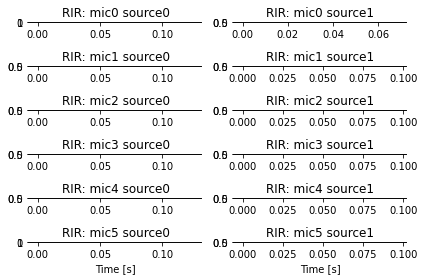

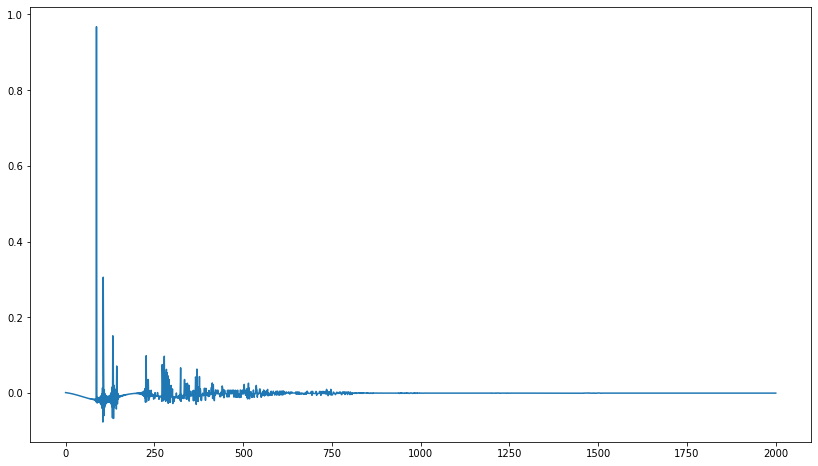

In [2]:
sampling_frequency = 16000
fft_length = 512
fft_shift = 256
mic_diameter = 0.1
sound_speed = 343
look_direction = 90

signal = audioread("/home/wangwei/work/DistantSpeech/samples/audio_samples/5_541_20170608093550_3.wav")
# signal = audioread("/home/wangwei/work/DistantSpeech/samples/audio_samples/cleanspeech_aishell3.wav")
noise = audioread("/home/wangwei/work/DistantSpeech/samples/noise/office3.wav")
fs = 16000
M = 6
mic_array = MicArray(arrayType="linear", r=mic_diameter/2, M=M, n_fft=512)
mic_array_sim = mic_array.array_sim
# print(mic_array_sim.R)
array_data, premix = mic_array_sim.generate_audio(signal, interference=noise, source_angle=look_direction, interf_angle=270, sir=10, snr=20)
theoretical=True
# audiowrite('mix.wav', np.transpose(array_data))
# audiowrite('signal.wav', np.transpose(premix[0, :, :]))
# audiowrite('interf.wav', np.transpose(premix[1, :, :]))

print(array_data.shape)
M = array_data.shape[0]
transform = Transform(n_fft=512, hop_length=256, channel=M)
D = transform.stft(np.transpose(array_data))
# transform = Transform(n_fft=512, hop_length=256, channel=M)
# target = transform.stft(np.transpose(premix[0, :M, :]))
# transform = Transform(n_fft=512, hop_length=256, channel=M)
# Noise = transform.stft(np.transpose(premix[1, :M, :]))
# print(Noise.shape)
half_bin = D.shape[0]
frame_num = D.shape[1]
print(D.shape)
plt.figure(figsize=(14,8))
plt.plot(mic_array_sim.room.rir[0][0])
plt.show()

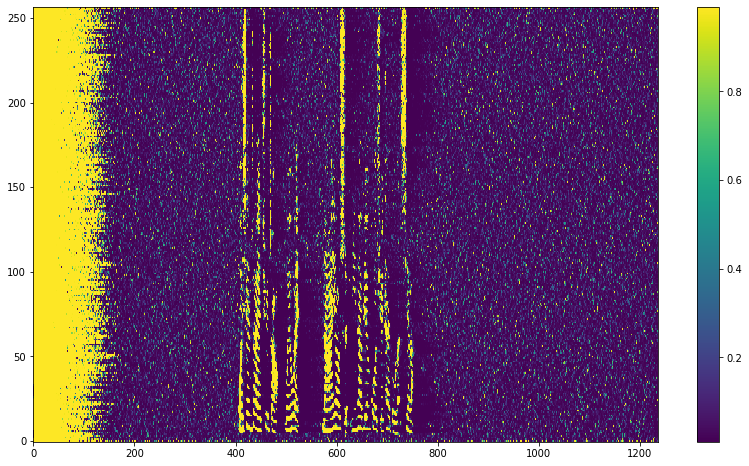

(316761,)


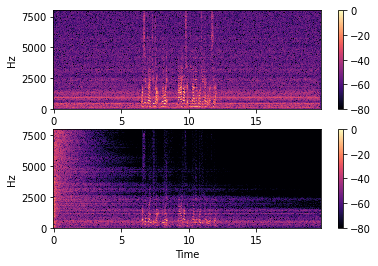

In [3]:
frameLen = 256
hop = frameLen / 2
overlap = frameLen - hop
nfft = 512
c = 340
# r = 0.032
# fs = 16000

# start = tim


start = time()

fdgsc = FDGSC(mic_array, frameLen, hop, nfft, c, fs)

yout, p = fdgsc.process(array_data)
pmesh(p)
print(yout.shape)

# audiowrite('wav/out_aic.wav', yout)

# end = time()
# print(end - start)

visual(array_data[0, :], yout)


In [4]:
print(p.shape)
audiowrite('out_aic.wav', yout)

(257, 1237)


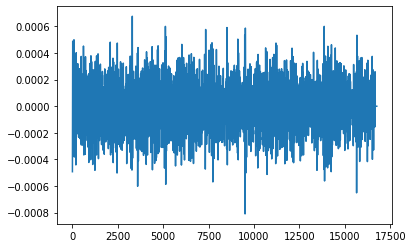

In [5]:
plt.figure()
plt.plot(yout[300000:])
plt.show()